# Visualising the pulsar data

This notebook visualises the frequency, $v$, vs phase data, $\phi$, recorded from the 42 ft telescope at JBO. 

The dispersion in the data is used to calculate the dispersion mesaure $DM$.

Finally, an optimization program is run to obtain the de-dispersed data.

In [69]:
# Imports and preamble
from __future__ import (print_function, absolute_import, division)
import os
import scipy.optimize as opt

import numpy as np
import scipy

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime

from  matplotlib import pyplot as plt
import matplotlib

from math import pi

%matplotlib inline
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

pulsar_name = 'B0329_54Tue(1)'

## 1. Data Functions

### 1.1 Reading Data

In [3]:
# Get the data directory path
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP")

def read_data(file_name):
    """
    Reads the data from ascii files.
    
    @param file_name :: name of the file
    
    @returns :: three arrays with the channel counts,
                phase_counts and data.
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(data_dir, file_name)
    
    chan_count, phase_count, data = \
    np.loadtxt(data_file, usecols=(1,2,3), unpack=True, skiprows=1)
    
    return chan_count, phase_count, data

### 1.2 Organising Data

In [4]:
def get_numbers(chan_count, phase_count):
    """
    Gets the number of channels and the
    number of phase bins of the data.
    
    @param chan_count :: channel counts as read from 
                         the data file
    @param phase_count :: same for phase
    
    @returns :: number of channels and number of phases
    """
    
    nchan=int(chan_count[-1])+1
    nphase=int(phase_count[-1])+1
    
    return nchan, nphase


def reshape_data(nchan, nphase, data):
    """
    Reshapes the data into 2d structure so it is usable.
    
    @param nchan :: number of frequency channels
    @param nphase :: number of phase bins
    @param data :: intensity data
    
    @returns :: 2d data structure, array of channels and
                array of phases
    """
    
    raw = data.reshape(nchan,nphase)
    iphase = phase_count.reshape(nchan,nphase)[0] 
    ichan = chan_count.reshape(nchan,nphase)[:,0]
    
    return raw, ichan, iphase


def freq_integral(raw):
    """
    Takes the data and integrates it over all
    frequency channels.
    
    @param raw :: 2d data structure
    
    @returns :: data integrated along frequency
    """
    
    integrated = np.sum(raw, axis=0)
    
    return integrated


def convert_axis(ichan, iphase):
    """
    Convert the channels of frequency and the phase
    array into physical things.
    
    @param ichan :: array of channels of data
    @param iphase :: array of phases of data
    
    @returns :: array of frequencies and array of times
    """
    
    freq = 605.125 + ichan * (10/nchan)
    time = iphase*(0.71452/nphase)
    
    return freq, time

### 1.3 Plotting the data

In [5]:
def density_plot(data, freq, time):
    """
    Function that makes a density plot of some data.
    
    @param data :: data of the density plot
    @param freq :: frequencies (y-axis)
    @param time :: times (x-axis)
    
    @returns :: density plot
    """
    
    dens_plot = plt.figure(figsize=(12,12))
    plt.subplot(211)
    plt.imshow(data, aspect='auto', origin='lower', 
               extent=(time[0],time[-1],freq[0],freq[-1]))
    plt.title("Density Plot")
    plt.xlabel("Time (s)",)
    plt.ylabel("Frequency (MHz)")
    plt.subplots_adjust(bottom=0.1, top=0.9)


def intensity_plot(integrated, time):
    """
    Function that makes an intensity plot of some data.
    
    @param integrated :: y-data of the intensity plot
    @param time :: x-data of the intensity plot
  
    @returns :: intensity plot
    """
    
    intens_plot = plt.figure(figsize=(12,12))
    plt.subplot(211)
    plt.plot(time, integrated)
    plt.xlabel("Phase (iphase)")
    plt.ylabel("Intensity (Arbitrary)")
    plt.title("Integrated profile")
    plt.subplots_adjust(bottom=0.1, top=0.9)

### 2. Dispersion Measure Functions

### 2.1 Shifting

In [6]:
def shift_rows(data_in, nchan, shifts):
    """
    Shifts the rows of the data by amount in variable "shifts".
    
    @param data_in :: data to be shifted
    @param shifts :: amount to be shifted by
    
    @returns :: sifted data
    """
    
    shifted=np.zeros_like(data_in)
    for chan in range(nchan):
        shifted[chan] += np.roll(data_in[chan], -int(shifts[chan]))
    return shifted

def shifting(x, constants):
    """
    Shifts the data by an array times the variable m.
    Tries to dedisperse the data this way.
    
    @param constants :: array of constants i.e. raw_data,
                        freq, nphase
    
    @returns :: negative of the maximum of the integrated frequency
    """
    
    bindelay = (x[0] * 4148.8 * constants[2])/(0.71452 * pow(constants[1], 2))
    dedispersed = shift_rows(constants[0], nchan, bindelay)
    integrated = np.sum(dedispersed, axis=0)
    
    return -np.amax(integrated)


def shifting_results(x, constants):
    """
    Does the same thing as function shifting.
    
    @returns :: the bindelay, dedispersed and integrated
                numpy arrays
    """
    
    bindelay = (x[0] * 4148.8 * constants[2])/(0.71452 * pow(constants[1], 2))
    dedispersed = shift_rows(constants[0], nchan, bindelay)
    integrated = np.sum(dedispersed, axis=0)
    
    return bindelay, dedispersed, integrated

### 2.2 Dispersion Measure Through Optimization

In [7]:
def find_dispersion(shifting, initial_guess, constants):
    """
    Finds the dispersion measure using minimization.
    
    @param initial_guess :: gets the initial guess of the data
    @param shifting :: the shifting function
    @param constants :: array of constants
    
    @returns :: the bindelay, dedispersed and integrated arrays
    """
    
    res = opt.minimize(shifting, [initial_guess], constants, method="Nelder-Mead")
    
    return res.x[0], res.fun

## 3. Kowalski, Analysis.

In [70]:
# Get the needed data
chan_count, phase_count, data = read_data(pulsar_name)
nchan, nphase = get_numbers(chan_count, phase_count)
raw, ichan, iphase = reshape_data(nchan, nphase, data)
integrated = freq_integral(raw)
freq, time = convert_axis(ichan, iphase)

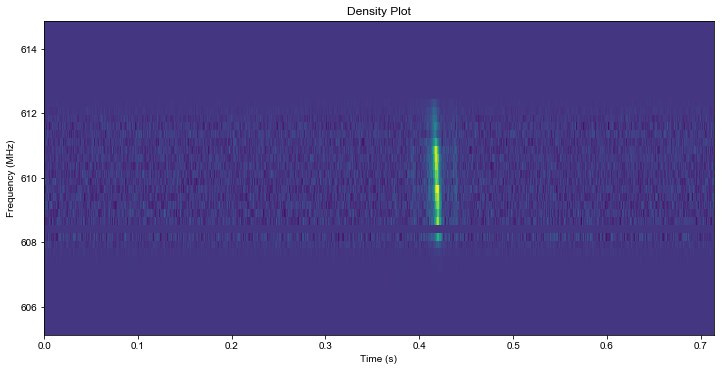

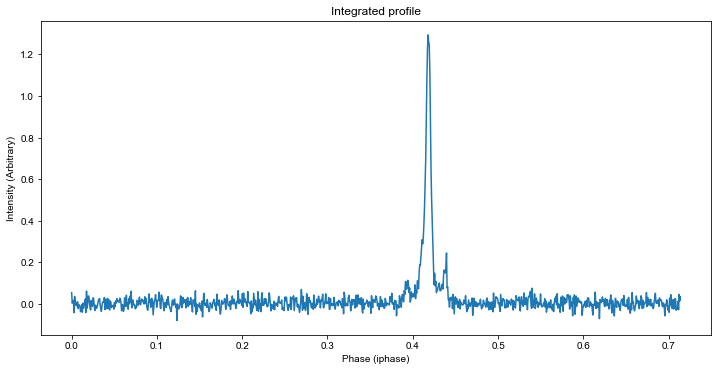

In [9]:
density_plot(raw, freq, time)
intensity_plot(integrated, time)

### 3.1 Generate Data for Soumya

Fitting and roughly approximating DM method.

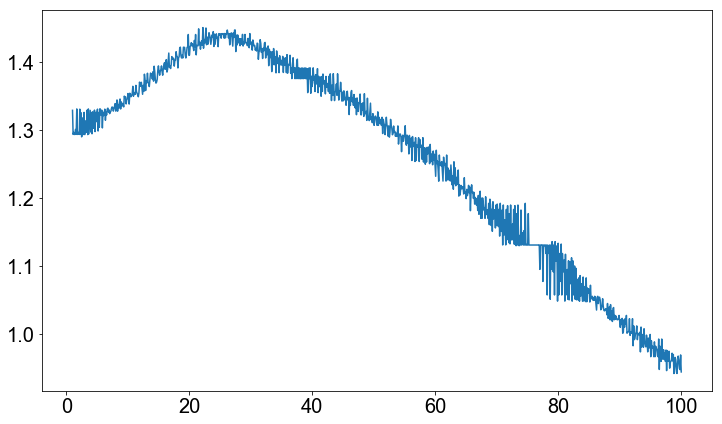

In [77]:
# Generate data for Soumya
dms = np.linspace(1,100,1000)
intensity_peaks = []
for i, guess in enumerate(dms):
    intensity_peaks.append(-shifting([guess], [raw, freq, nphase, nchan]))

data = np.array([dms, intensity_peaks])
data = np.transpose(data)

np.savetxt(data_dir + os.sep + pulsar_name + '.txt', data, fmt="%.7f")

plt.figure(figsize=(12,7))
plt.plot(data[:,0], data[:,1])
plt.show()

### 3.2 Histogram Method

This uses optimization to find dm. Needs fine tuning from the user.

In [79]:
n = 1000
tries = np.linspace(26,27,n)
data = []
for i, init_guess in enumerate(tries):
    disp_measure, function_val = \
    find_dispersion(shifting, init_guess, [raw, freq, nphase, nchan])
    data.append([init_guess, disp_measure, -function_val])

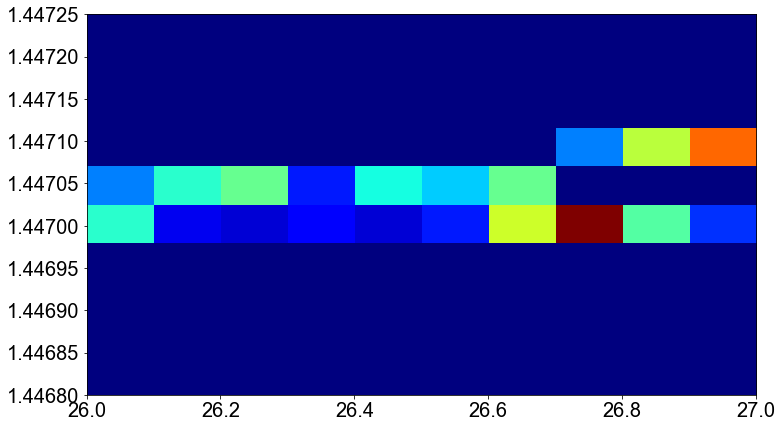

In [80]:
data = np.asarray(data)

plt.figure(figsize=(12,7))
plt.hist2d(data[:,1], data[:,2], 10, range = [[26,27], [1.4468, 1.44725]], cmap = 'jet')
plt.show()

#### 3.2.2 Time Delay vs Frequency

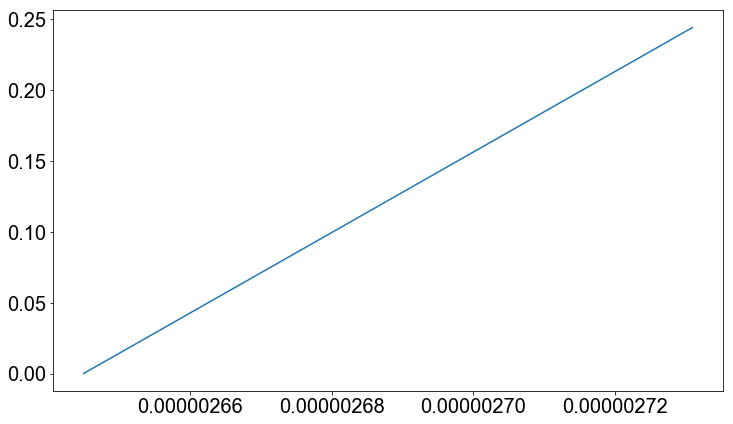

In [100]:
idxs = np.where(np.logical_and(data[:,1] > 26.7, data[:,1] < 26.8))[0]

good_dm = []
for i in range(0, len(idxs)):
    good_dm.append(data[:,1][idxs[i]])

mean_dm = np.mean(good_dm)
bindelay, dedispersed, integrated = \
shifting_results([mean_dm], [raw, freq, nphase, nchan])

bindelay = bindelay*0.71452/nchan
bindelay = bindelay-bindelay[-1]

data = np.array([freq**(-2), bindelay])

plt.figure(figsize=(12,7))
plt.plot(freq**(-2), bindelay)
plt.show()

### 3.3 Monte Carlo Method

In [ ]:
# Arxiv: 1402.1672



## 4. Noise Estimation

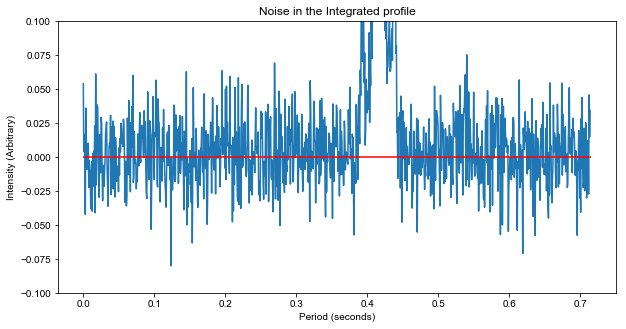

Statistical Uncertainty due to Noise = 0.0216001948998


In [12]:
# Plots the noise in the date
plt.figure(figsize=(10,5))
plt.plot(time,integrated, zorder=1)
plt.hlines(y=0,xmin=0, xmax=0.71452, colors='r', linestyles='solid', zorder=2)
plt.xlabel("Period (seconds)")
plt.ylabel("Intensity (Arbitrary)")
plt.title("Noise in the Integrated profile")
axes = plt.gca()
# If noise is larger, limits need to be changes to estimate upperbound
axes.set_ylim([-0.1,0.1])
plt.show()

# calculates the noise in the integrated array + estimates the uncertainty
Noise = integrated[np.where(integrated < 0.05)]
ErrNoise = np.std(Noise)
print("Statistical Uncertainty due to Noise = {}".format(ErrNoise))